Price       0
Size        0
Installs    0
Reviews     0
Rating      0
Category    0
App Name    0
dtype: int64


,Rating,Reviews,Installs,NPriceD,NSizeM,Installs_logscale,Reviews_logscale
Rating,1.000000,0.058658,0.035402,-0.033268,0.045972,0.028701,0.112516
Reviews,0.058658,1.000000,0.741567,-0.017392,0.085281,0.344739,0.391491
Installs,0.035402,0.741567,1.000000,-0.024050,0.066331,0.357884,0.351328
NPriceD,-0.033268,-0.017392,-0.024050,1.000000,-0.013826,-0.086083,-0.062478
NSizeM,0.045972,0.085281,0.066331,-0.013826,1.000000,0.119462,0.102511
Installs_logscale,0.028701,0.344739,0.357884,-0.086083,0.119462,1.000000,0.923647
Reviews_logscale,0.112516,0.391491,0.351328,-0.062478,0.102511,0.923647,1.000000


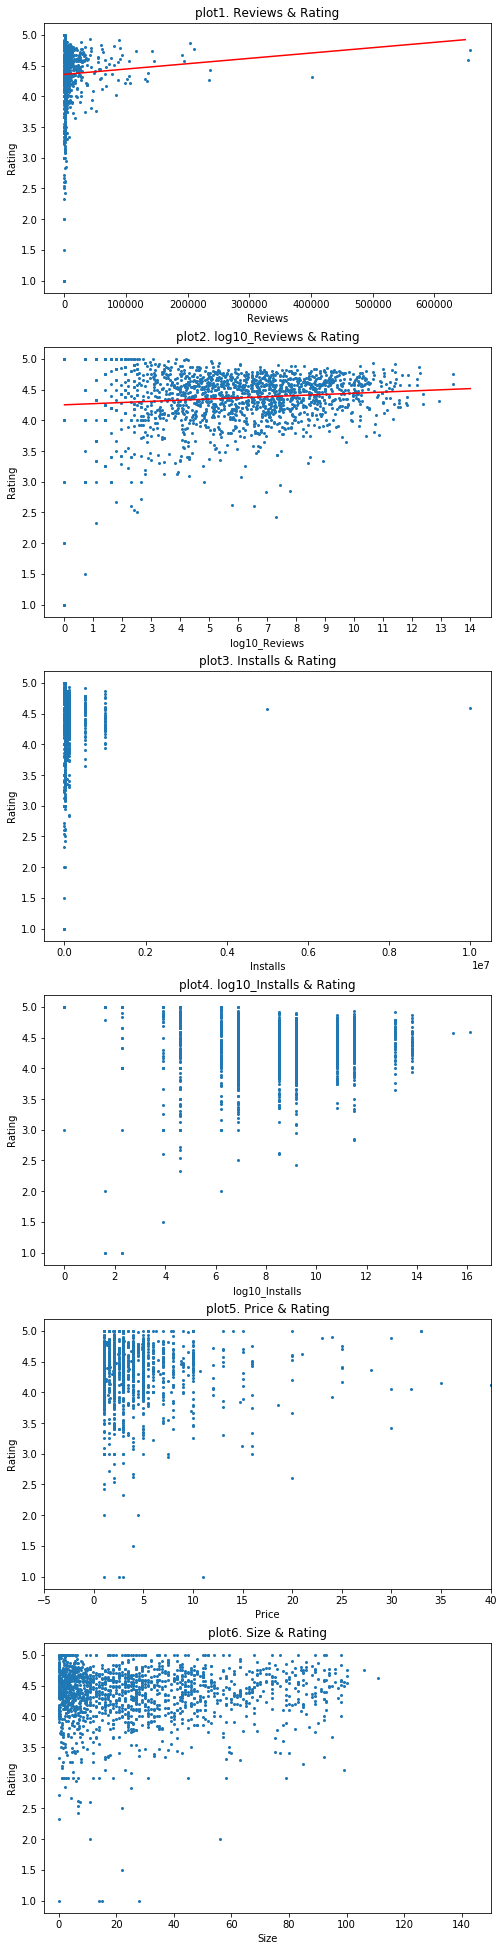

In [1]:
#필요한 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

app_store_df = pd.read_csv("./app_store.csv")
total = app_store_df.isnull().sum().sort_values(ascending=False)
print(total)
app_store_df['NPriceD'] = app_store_df.Price.map(lambda x : float(x[1:]))
app_store_df['NSizeM'] = app_store_df.Size.map(lambda x : float(x.rstrip('M').replace(',','')) if(x[-1] == 'M') else float(x.rstrip('k').replace(',',''))/1000)
app_store_df['Installs'] = app_store_df.Installs.map(lambda x : int(x.rstrip('+').replace(',','')))
app_store_df['Installs_logscale'] = app_store_df.Installs.map(lambda x : np.log(x))
app_store_df['Reviews_logscale'] = app_store_df.Reviews.map(lambda x : np.log(x))
total = app_store_df.isnull().sum().sort_values(ascending=False)
app_store_df.to_csv('app_store_modified.csv')

plt.figure(figsize = (8,30))
plt.subplots_adjust(top=1)
columns = ['Reviews','Reviews_logscale','Installs','Installs_logscale', 'NPriceD', 'NSizeM']
ylabels = ['Reviews','log10_Reviews','Installs','log10_Installs', 'Price', 'Size']
reg1 = LinearRegression().fit(X = app_store_df['Reviews_logscale'].values.reshape(-1,1), y = app_store_df.Rating)
reg2 = LinearRegression().fit(X = app_store_df['Reviews'].values.reshape(-1,1), y = app_store_df.Rating)
for i in list(range(6)):
    plt.subplot(6,1,i+1)
    plt.title('plot'+str(i+1)+'. '+ylabels[i]+' & Rating')
    plt.ylabel('Rating')
    plt.xlabel(ylabels[i])
    if i == 1:
        plt.xticks(list(range(20)))
    elif i == 4:
        plt.xlim(-5,40)
    elif i == 5:
        plt.xlim(-5,150)
    plt.plot( app_store_df[columns[i]],app_store_df.Rating,'o',markersize=2)
    if i == 1:
        plt.plot([0,14],reg1.predict([[0],[14]]),color = 'r')
    elif i == 0:
        plt.plot([1,650000],reg2.predict([[1],[650000]]),color = 'r')

app_store_df.corr()

In [6]:
#카테고리별 아노바 분석
import scipy.stats as stats

all_categories = []
for i in list(range(len(app_store_df))):
    if app_store_df['Category'][i] in all_categories:
        pass
    else:
        all_categories.append(app_store_df['Category'][i])
group_edu = app_store_df[app_store_df['Category']=="EDUCATION"]

ANOVA_pairs = []
for i in list(range(len(all_categories))):
    for j in list(range(i+1, len(all_categories))):
        if stats.f_oneway(app_store_df['Rating'][app_store_df['Category'] == all_categories[i]],
               app_store_df['Rating'][app_store_df['Category'] == all_categories[j]]).pvalue <= 0.05:
               ANOVA_pairs.append([all_categories[i],all_categories[j]])
for i in ANOVA_pairs:
    if i[0] > i[1]:
        print(i[0]+' > '+i[1])
    else:
        print(i[0]+' < '+i[1])

GAME_MUSIC > DATING
GAME_MUSIC < WEATHER
GAME_EDUCATIONAL < GAME_SPORTS
GAME_EDUCATIONAL < PERSONALIZATION
GAME_EDUCATIONAL > DATING
GAME_EDUCATIONAL > EVENTS
GAME_EDUCATIONAL < SOCIAL
GAME_EDUCATIONAL < WEATHER
EDUCATION < GAME_SIMULATION
EDUCATION < GAME_ACTION
EDUCATION < GAME_SPORTS
EDUCATION < LIFESTYLE
EDUCATION < GAME_CASUAL
EDUCATION > DATING
EDUCATION < MEDICAL
EDUCATION < EVENTS
EDUCATION < SOCIAL
EDUCATION < TRAVEL_AND_LOCAL
BOOKS_AND_REFERENCE < GAME_SIMULATION
BOOKS_AND_REFERENCE < GAME_ACTION
BOOKS_AND_REFERENCE < GAME_SPORTS
BOOKS_AND_REFERENCE < LIFESTYLE
BOOKS_AND_REFERENCE < GAME_CASUAL
BOOKS_AND_REFERENCE < DATING
BOOKS_AND_REFERENCE < MEDICAL
BOOKS_AND_REFERENCE < EVENTS
BOOKS_AND_REFERENCE < SOCIAL
ENTERTAINMENT < GAME_STRATEGY
ENTERTAINMENT < GAME_PUZZLE
ENTERTAINMENT < PERSONALIZATION
ENTERTAINMENT > DATING
ENTERTAINMENT < EVENTS
ENTERTAINMENT < WEATHER
GAME_SIMULATION > GAME_ROLE_PLAYING
GAME_SIMULATION < GAME_STRATEGY
GAME_SIMULATION < GAME_SPORTS
GAME_SIMULATI

In [5]:
229%3

1